In [108]:
# loading libraries for data manipulation
import numpy as np
import pandas as pd

# loading libraries for data visualization
import matplotlib.pyplot as plt
from plotnine import *
from PIL import Image

# import tensorflow and keras packages
import tensorflow as tf
from tensorflow import keras

# import PCA adn tSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

#### PCA and Linear Autoencoders

We can compare PCA with a simple linear autoencoder and in doing so, we can understand the syntax for an autoencoder. 

We will utilize the MNIST digits data again. 

In [109]:
# load data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# we will convert our images into 1x784 vectors
X_train = X_train.reshape(-1, 28*28).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28*28).astype('float32') / 255.0

We don't need the digit labels for autoencoders - these are "almost" unsupervised models. 

In [110]:
# set dimensions for latent space
latent_dim = 64 # 1x64 64 numbers in a vector will be used to compress our inputs

Let's apply PCA to the inputs. 

In [112]:
pca = PCA(n_components=latent_dim) # generate 64 principal components
X_train_pca = pca.fit_transform(X_train) # learn representation on training input
X_test_pca = pca.transform(X_test) # apply to test input

X_test_pca_reconstructed = pca.inverse_transform(X_test_pca) # reconstruct input 

Let's define our autoencoder. Recall that an autoencoder network is built on Encoder and Decoder blocks. 

In [113]:
# define input
input_img = tf.keras.layers.Input(shape=(784,))

# encoder (linear)
encoded = tf.keras.layers.Dense(latent_dim,activation=None)(input_img)

# decoder (linear)
decoded = tf.keras.layers.Dense(784,activation=None)(encoded)

# the entire model
linear_autoencoder = tf.keras.Model(input_img,decoded)

Let's compile and train our linear autoencoder. 

In [114]:

linear_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss="mse")

linear_autoencoder.fit(X_train,X_train, # input and output are the same
                       epochs=20,
                       batch_size=128,
                       shuffle=True,
                       validation_data=(X_test,X_test),
                       verbose=1)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0270 - val_loss: 0.0124
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0109 - val_loss: 0.0097
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0098 - val_loss: 0.0093
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0096 - val_loss: 0.0092
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

In [115]:
# linear autoencoder model architecture
linear_autoencoder.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 784)            │        50,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,602 (1.16 MB)

 Trainable params: 101,200 (395.31 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 202,402 (790.64 KB)

Let's now reconstruct our inputs using the autoencoder and compare with the PCA reconstructions. 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


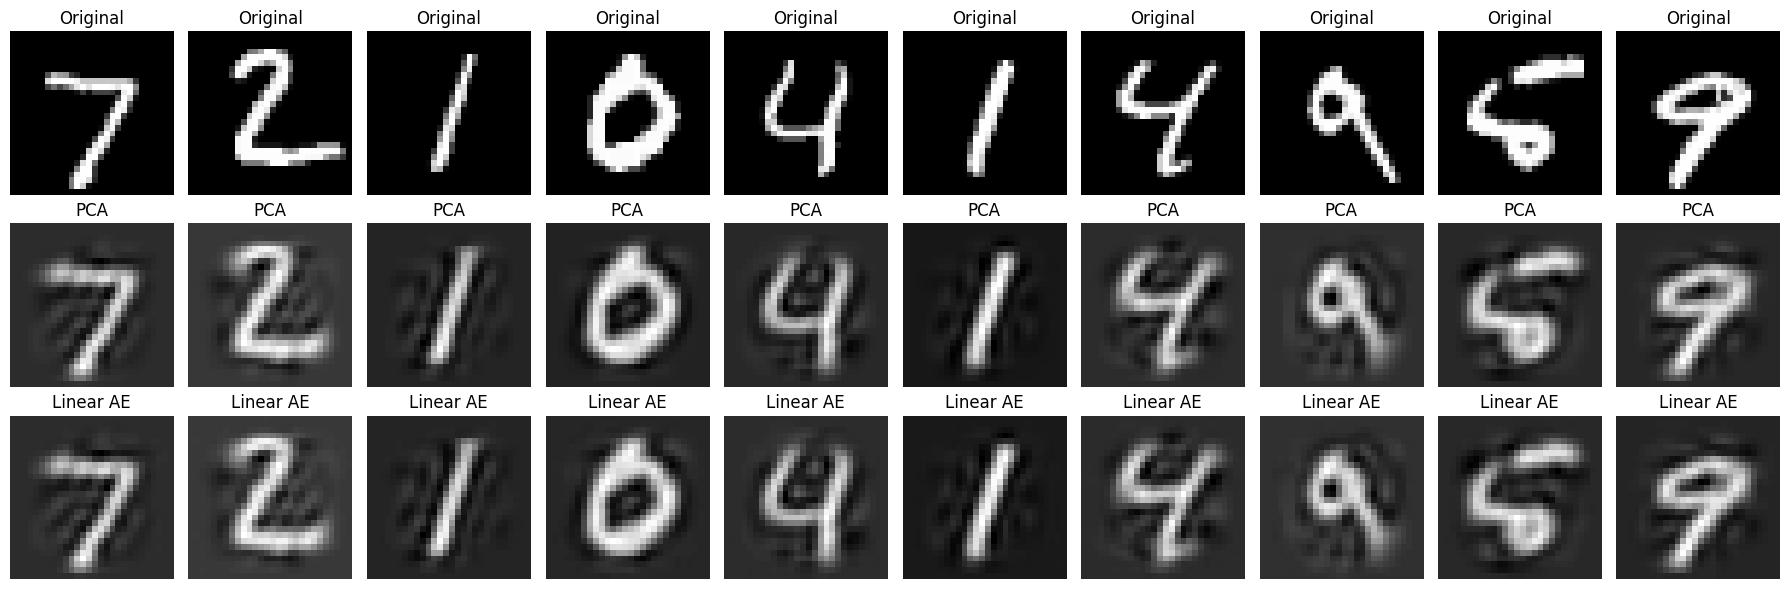

In [116]:
# predict test images
X_test_ae_reconstructed = linear_autoencoder.predict(X_test)

# visualization function 
def plot_reconstructions(input,pca_output,ae_output,n=10):
    plt.figure(figsize=(18, 6))
    for i in range(n):
        # Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(input[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # PCA
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(pca_output[i].reshape(28, 28), cmap="gray")
        plt.title("PCA")
        plt.axis("off")

        # Autoencoder
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(ae_output[i].reshape(28, 28), cmap="gray")
        plt.title("Linear AE")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# pass in parameters to the function
plot_reconstructions(X_test, X_test_pca_reconstructed, X_test_ae_reconstructed)


The reconstructions are almost identical. This adds weight to the notion that linear autoencoders are a form of PCA technique. 

#### Deep Autoencoder

Let's now train a deep non-linear autoencoder. The expectation here is that the latent space will learn a better representation of the inputs. 

In [ ]:
# define input
input_img = ...

# encoder (linear)
encoded = ...

# decoder (linear)
decoded = ...

# the entire model
deep_autoencoder = ...

In [ ]:
deep_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss="binary_crossentropy") # since we predict between [0,1]

deep_autoencoder.fit(X_train,X_train, # input and output are the same
                       epochs=10,
                       batch_size=128,
                       shuffle=True,
                       validation_data=(X_test,X_test),
                       verbose=1) 

In [ ]:
# reconstruction input using deep autoencoder
X_test_deep_ae_reconstructed = deep_autoencoder.predict(X_test)

# visualization function 
def plot_reconstructions(input,ae_output,n=10):
    plt.figure(figsize=(18, 6))
    for i in range(n):
        # Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(input[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Autoencoder
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(ae_output[i].reshape(28, 28), cmap="gray")
        plt.title("Deep AE")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_reconstructions(X_test,X_test_deep_ae_reconstructed,n=10)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


This indicates that an image of a digit can be compressed into a 1x64 vector that is the latent representation of the digit space. Let's use a dimensionality reduction algorithm to plot these representations in 2D for each digit. We will use t-SNE for this example. 

In [57]:
# first we extract the trained encoder from the network
encoder = tf.keras.Model(inputs=deep_autoencoder.input, outputs=encoded)

# next we get the latent representation of the test images
latent_vectors = encoder.predict(X_test)  # shape: (num_samples, 64)

# now we run t-SNE on these vectors
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


In [ ]:
# plot the representation in 2 dimensions
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_test, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE of Encoded MNIST Digits (64D → 2D)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

The plot above shows that the deep autoencoder has learned to represent most digits separate from the others. That is, the latent vectors may have captured information like stroke width, edges, curves etc. to learn how digits differ from one another. 

#### Denoising Autoencoders

Let's now apply some noise to our inputs before being fed into the network to create a denoising autoencoder. 

In [ ]:
noise_factor = 0.2

# add noise to X_train
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# clip noise to [0,1]
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

Repeat the deep autoencoder network but this time using noisy data as input and clean data as output. 

In [ ]:
# define input
input_img = tf.keras.layers.Input(shape=(784,))

# encoder (linear)
encoded = ...

# decoder (linear)
decoded = ...

# the entire model
denoising_autoencoder = ...

denoising_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss="binary_crossentropy") # since we predict between [0,1]

denoising_autoencoder.fit(X_train_noisy,X_train, # input and output are the same
                       epochs=10,
                       batch_size=128,
                       shuffle=True,
                       validation_data=(X_test_noisy,X_test),
                       verbose=1) 

In [ ]:
X_test_denoised = denoising_autoencoder.predict(X_test_noisy)

# visualization function 
def plot_reconstructions(input,noisy_input,ae_output,n=10):
    plt.figure(figsize=(18, 6))
    for i in range(n):
        # Noisy input
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy_input[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Ground truth
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(input[i].reshape(28, 28), cmap='gray')
        plt.title("Clean")
        plt.axis('off')

        # Denoised output
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(ae_output[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_reconstructions(X_test,X_test_noisy,X_test_denoised,n=10)

Let's also create a denoising convolutional autoencoder. 

In [60]:
# load data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# add channel information: (batch size, height, width, channels)
X_train = np.expand_dims(X_train, axis=-1)  # (60000, 28, 28, 1)
X_test = np.expand_dims(X_test, axis=-1)

In [61]:
# add noise
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [ ]:
# define the denoising convolutional autoencoder
input_img = tf.keras.layers.Input(shape=(28,28,1))

# encoder


# decoder


denoising_c_autoencoder = ...

In [ ]:
# view the network architecture
denoising_c_autoencoder.summary()

In [ ]:
# compile model
denoising_c_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy')

# train model
denoising_c_autoencoder.fit(
    X_train_noisy, X_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test_noisy, X_test),
    verbose=1
)

In [ ]:
# predict using autoencoder
X_test_denoised = denoising_c_autoencoder.predict(X_test_noisy)

# visualization function
def plot_reconstructions(input,noisy_input,ae_output,n=10):
    plt.figure(figsize=(18, 6))
    for i in range(n):
        # Noisy input
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy_input[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Ground truth
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(input[i].reshape(28, 28), cmap='gray')
        plt.title("Clean")
        plt.axis('off')

        # Denoised output
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(ae_output[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_reconstructions(X_test,X_test_noisy,X_test_denoised,n=10)

In the above network we used UpSampling2D to upsample a feature map. Upsampling2D is purely deterministic (there is no learning or probabilities involved). It simply increases spatial dimensions by repeating or interpolating values. 

A Conv2DTranspose on the other hand also increases the spatial dimensions but does so by learning kernels. It works like a reverse of Conv2D by spreading the input into a larger output shape. That does mean there are more parameters to learn for the network. 

For simple and quick upsampling, use UpSampling2D followed by a Conv2D layer. 

Let's checkout how Conv2dTranspose works with CIFAR-10 dataset. 

In [ ]:
# load data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype("float32") / 255.
X_test = X_test.astype("float32") / 255.

# define input dimensions
input_img = tf.keras.layers.Input(shape=(32,32,3))

# encoder

# decoder

autoencoder = ...

autoencoder.summary()


In [ ]:
# compile model
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy')

# train model
autoencoder.fit(
    X_train, X_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1
)

In [ ]:
# predict using network
X_test_reconstructed = autoencoder.predict(X_test)

# visualization function
def plot_reconstructions(input, ae_output, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(input[i])
        plt.title("Original")
        plt.axis('off')

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(ae_output[i])
        plt.title("Reconstructed")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_reconstructions(X_test, X_test_reconstructed)

Let's also take the latent representations, flatten them, and run them through t-SNE to see if we can find observable differences in the latent representation of images

In [86]:
# first extract the encoder
encoder = tf.keras.Model(inputs=autoencoder.input, outputs=encoded)

# then get the latent representations of the images
encoded_imgs = encoder.predict(X_test)

# next flatten the representations into 1x1024 dimensional vectors (4x4x128 = 1024)
flattened = encoded_imgs.reshape(len(encoded_imgs), -1)  

tsne = TSNE(n_components=3, perplexity=30)
embeddings = tsne.fit_transform(flattened) # 3 dimensional embeddings


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# cifar-10 labels
cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# 3D projection
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    embeddings[:, 0], embeddings[:, 1], embeddings[:, 2],
    c=y_test.squeeze(), cmap='tab10', s=5
)

# set labels
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title("3D Visualization of Latent Space")

# create legend with class names
cbar = plt.colorbar(scatter, ticks=range(10), pad=0.1)
cbar.ax.set_yticklabels(cifar10_labels)
cbar.set_label('Class')

plt.show()


Note that the goal of these networks is image reconstruction - not image classification. This means that even a deep autoencoder may not fully perform image classification simply because it has learned to compress the image into a latent diemnsion vector. 